# Exercise 3

In this assignment, you will find numerical solutions to the diffusion equation. In particular, you will use an implicit method, and consider problems with both Dirichlet and Neumann boundary conditions.

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it

## Problem Overview

The 1D diffusion equation is :

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
\end{pmatrix}$$

$$b = \begin{pmatrix}
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
\end{pmatrix}$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

First, write functions that will construct the matrix equation and boundary value term.

In [1]:
#%matplotlib notebook
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm



class Rod:
    def __init__(self,x,seg,dt,d0,dN,u0,k):
        '''Initialise class for material
        
        x - rod length;
        seg - no. segments to divide rod into;
        dt - time step between iterations;
        d0 - x0 Dirichlet boundary condition;
        dN - xN Dirichlet boundary condition;
        u0 - initial rod temperature;
        k - thermal diffusivity, calcuated by: thermal conductivity / density*specific heat'''

        self.x = x
        self.k=k
        self.seg=seg
        self.dt=dt
        self.step=x/seg
        self.d0 = d0
        self.dN = dN
        self.a = (k * dt) / self.step**2
        self.u = np.full((seg - 2), u0)

    def matmaker(self, b_type):
        '''initialise matrix for given problem
        
        b_type - 0 for Dirichlet problem (part 1), 1 for Neumann problem (part 2)'''
        
        mat=np.full((self.seg -2 ,self.seg - 2),(-self.a))
        mat=np.tril(np.triu(mat,-1),1)

        for i in range(0,self.seg -2):
            mat[i,i]=1 + 2*self.a

        if b_type != 0:
            mat[0,0] = 1 + self.a
        
        return mat

    def boundary(self,b_type):
        '''set dirichlet boundary conditions for given problem
        
        b_type - 0 for Dirichlet problem (part 1), 1 for Neumann problem (part 2)'''
        vect=np.zeros(self.seg - 2)

        if b_type == 0:
            vect[0] = -self.a * self.d0

        vect[-1] = -self.a * self.dN

        return vect

    def plotter(self,f_u,timesteps):
        '''plot 3D graph of heat distribution over time
        
        Args:
        f_u - array holding u(x,t) data;
        timesteps - no. iterations performed'''

        xr = np.arange(0,self.seg - 2,1)
        yr = np.arange(0,timesteps,1)*self.dt

        X,Y = np.meshgrid(xr,yr)
        X = X/(np.amax(X)) * self.x

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, f_u, vmin=f_u.min() * 2, cmap=cm.hot)
        ax.set_xlabel('Position (m)')
        ax.set_ylabel('Time (s)')
        ax.set_zlabel('Temperature (K)')

        plt.show()
    
    def time_iterator(self, timesteps, b_type):
        '''find temp distribution by time
        
        Args: 
        timesteps - no. time steps;
        b_type - Boundary conditions: 0 for Dirichlet conditions (part 1), 1 for Neumann (part 2)
        '''

        mat = self.matmaker(b_type) #use function to generate matrix based on specified boundary conditions
        bound = self.boundary(b_type) #generate specified boundary condition vector
        f_u = np.zeros((timesteps, self.seg - 2)) #initialise storage array for u(x,t)
        f_u_error = np.zeros((timesteps, self.seg - 2))

        f_u [0,:] = linalg.solve(mat,(self.u - bound)) #initialise first column for iterating
        f_u_error [0,:] = mat @ f_u [0,:] + bound - self.u

        for i in range(1,timesteps): #iterate until equilibrium or timestep limit reached
            f_u[i,:] = linalg.solve(mat ,(f_u[i-1,:] - bound))
            f_u_error [i,:] = mat @ f_u [i,:] + bound - self.u

            if i > 10 and np.mean(f_u[i,:] - f_u[i-10,:]) < 0.005: #check if rod has reached equilibrium and finish iterating
                timesteps = i #store final number of iterations
                f_u = f_u[0:i,:] #remove surplus empty storage matrix columns
                f_u_error = f_u_error[0:i,:]
                print(f_u_error)
                break
                
        self.plotter(f_u,timesteps) #send rod temperature data and no. iterations to plotting function

segments = 100

timesteps = 50000
dt = 1

x = 0.5
d0 = 273
dN = 1273
u0 = 293

'''material data'''
iron_tc = 59
iron_density = 7900
iron_shc = 450
iron_tdiff = iron_tc / (iron_density * iron_shc)

cu_tc = 401
cu_density = 8960
cu_shc = 385
cu_tdiff = cu_tc / (cu_density * cu_shc)

'''initialise material classes'''
iron_50 = Rod(x,segments,dt,d0,dN,u0,iron_tdiff)
cu_50 = Rod(x, segments, dt, d0, dN, u0, cu_tdiff)

iron_mid = Rod(x, segments, dt, d0, dN, u0, iron_tdiff)


Now write a function which will transport the temperature distribution at time step $n$ to time step $n+1$. You will need to use an appropriate linear algebra routine.

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using an appropriate plotting routine.

[[ 0.00000000e+00  1.13686838e-13  1.70530257e-13 ... -1.13686838e-13
   1.13686838e-13 -1.13686838e-13]
 [-6.26333029e+00 -1.96146532e+00 -6.14265256e-01 ...  3.00989976e+01
   9.61118005e+01  3.06903184e+02]
 [-9.53927810e+00 -4.01329963e+00 -1.57811396e+00 ...  7.73275840e+01
   1.96651682e+02  4.67424627e+02]
 ...
 [-9.93587808e+00  1.28280990e-01  1.01925143e+01 ...  9.49586454e+02
   9.59724241e+02  9.69862102e+02]
 [-9.93585344e+00  1.28330247e-01  1.01925881e+01 ...  9.49586528e+02
   9.59724290e+02  9.69862126e+02]
 [-9.93582881e+00  1.28379472e-01  1.01926619e+01 ...  9.49586601e+02
   9.59724339e+02  9.69862151e+02]]


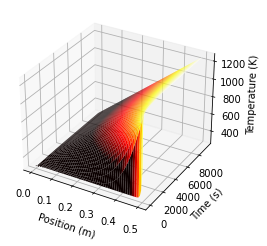

[[ 0.00000000e+00 -4.54747351e-13  4.54747351e-13 ...  0.00000000e+00
   0.00000000e+00 -9.09494702e-13]
 [-1.26295878e+01 -7.97532446e+00 -5.03625304e+00 ...  2.46776399e+02
   3.90790898e+02  6.18849804e+02]
 [-1.54823750e+01 -1.15782770e+01 -8.44903847e+00 ...  4.14002885e+02
   5.67335573e+02  7.58636373e+02]
 ...
 [-9.90422874e+00  1.91547798e-01  1.02873349e+01 ...  9.49681274e+02
   9.59787507e+02  9.69893751e+02]
 [-9.90420432e+00  1.91596601e-01  1.02874080e+01 ...  9.49681347e+02
   9.59787556e+02  9.69893775e+02]
 [-9.90418002e+00  1.91645176e-01  1.02874808e+01 ...  9.49681420e+02
   9.59787605e+02  9.69893800e+02]]


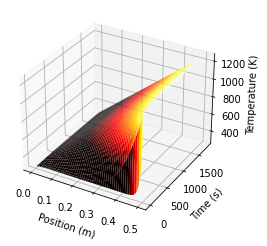

[[ 0.00000000e+00  1.13686838e-13  1.70530257e-13 ... -1.13686838e-13
   1.13686838e-13 -1.13686838e-13]
 [-6.26333029e+00 -1.96146532e+00 -6.14265256e-01 ...  3.00989976e+01
   9.61118005e+01  3.06903184e+02]
 [-9.53927810e+00 -4.01329963e+00 -1.57811396e+00 ...  7.73275840e+01
   1.96651682e+02  4.67424627e+02]
 ...
 [-9.93587808e+00  1.28280990e-01  1.01925143e+01 ...  9.49586454e+02
   9.59724241e+02  9.69862102e+02]
 [-9.93585344e+00  1.28330247e-01  1.01925881e+01 ...  9.49586528e+02
   9.59724290e+02  9.69862126e+02]
 [-9.93582881e+00  1.28379472e-01  1.01926619e+01 ...  9.49586601e+02
   9.59724339e+02  9.69862151e+02]]


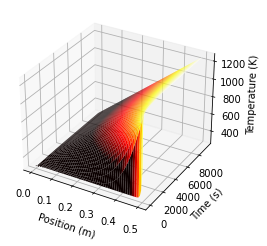

In [4]:
iron_50.time_iterator(timesteps, 0)
cu_50.time_iterator(timesteps, 0)
iron_mid.time_iterator(timesteps, 0)

## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the temperature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two nodes have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
\end{pmatrix}$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

First write any new functions you need. You should be able to re-use some functions from Part 1.

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using a sensible plotting function.

[[ 0.00000000e+00 -5.68434189e-14 -1.13686838e-13 ... -1.13686838e-13
   1.13686838e-13 -1.13686838e-13]
 [ 0.00000000e+00 -5.68434189e-14 -1.13686838e-13 ...  3.00989976e+01
   9.61118005e+01  3.06903184e+02]
 [ 0.00000000e+00 -5.68434189e-14 -1.13686838e-13 ...  7.73275840e+01
   1.96651682e+02  4.67424627e+02]
 ...
 [ 9.75372320e+02  9.75373497e+02  9.75375850e+02 ...  9.79778682e+02
   9.79852424e+02  9.79926202e+02]
 [ 9.75373101e+02  9.75374278e+02  9.75376631e+02 ...  9.79778720e+02
   9.79852448e+02  9.79926215e+02]
 [ 9.75373882e+02  9.75375059e+02  9.75377411e+02 ...  9.79778757e+02
   9.79852473e+02  9.79926227e+02]]


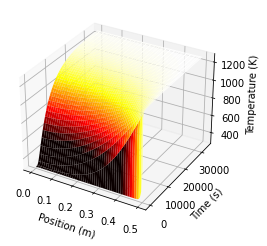

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.54747351e-13
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.46776399e+02
  3.90790898e+02 6.18849804e+02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.14002885e+02
  5.67335573e+02 7.58636373e+02]
 ...
 [9.79339942e+02 9.79340109e+02 9.79340445e+02 ... 9.79968433e+02
  9.79978951e+02 9.79989474e+02]
 [9.79340721e+02 9.79340889e+02 9.79341224e+02 ... 9.79968470e+02
  9.79978976e+02 9.79989486e+02]
 [9.79341500e+02 9.79341667e+02 9.79342002e+02 ... 9.79968507e+02
  9.79979000e+02 9.79989499e+02]]


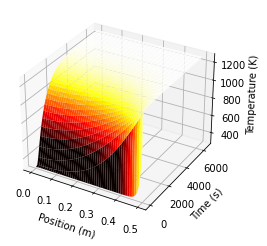

In [3]:
iron_50.time_iterator(timesteps, 1)
cu_50.time_iterator(timesteps, 1)

# Part 3

In the Markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained. You are not expected to write more than about 250-300 words.